<a href="https://colab.research.google.com/github/ZackYovel/using_genetic_algorithm_for_hyper_parameter_tuning/blob/MLK/using_genetic_algorithm_for_hyper_parameter_tuning_single_population_low_evolutionary_pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Genetic Algorithm for Hyper Parameter Tuning

## Using data from the kaggle Housing Prices Competition for Kaggle Learn Users

Using multiple populations.

Competition URL: https://www.kaggle.com/c/home-data-for-ml-course

In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import concurrent.futures
import random
import json
import os
import heapq
import time
import logging

random_gen = default_rng()

In [2]:
# Data load
project_files_path = os.path.join("drive", "My Drive", "Colab Notebooks", "Using Genetic Algorithm for Hyper Parameter Tuning (single population, low evolutionary pressure)")

train = pd.read_csv(os.path.join(project_files_path, "train.csv"))
X_test = pd.read_csv(os.path.join(project_files_path, "test.csv"))

X = train.drop(['SalePrice'], axis=1)
y = train.SalePrice

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
# Preprocess data

num_X_train = X_train.select_dtypes(exclude=['object'])
num_X_cv = X_cv.select_dtypes(exclude=['object'])
num_X_test = X_test.select_dtypes(exclude=['object'])

cat_X_train = X_train.select_dtypes(include=['object'])
cat_X_cv = X_cv.select_dtypes(include=['object'])
cat_X_test = X_test.select_dtypes(include=['object'])

# Imputation
most_frequent_num_imputer = SimpleImputer(strategy='most_frequent')
imputed_num_X_train = pd.DataFrame(most_frequent_num_imputer.fit_transform(num_X_train))
imputed_num_X_cv = pd.DataFrame(most_frequent_num_imputer.transform(num_X_cv))
imputed_num_X_test = pd.DataFrame(most_frequent_num_imputer.transform(num_X_test))

imputed_num_X_train.columns = num_X_train.columns
imputed_num_X_cv.columns = num_X_cv.columns
imputed_num_X_test.columns = num_X_test.columns

imputed_num_X_train.index = num_X_train.index
imputed_num_X_cv.index = num_X_cv.index
imputed_num_X_test.index = num_X_test.index

most_frequent_cat_imputer = SimpleImputer(strategy='most_frequent')
imputed_cat_X_train = pd.DataFrame(most_frequent_cat_imputer.fit_transform(cat_X_train))
imputed_cat_X_cv = pd.DataFrame(most_frequent_cat_imputer.transform(cat_X_cv))
imputed_cat_X_test = pd.DataFrame(most_frequent_cat_imputer.transform(cat_X_test))

imputed_cat_X_train.columns = cat_X_train.columns
imputed_cat_X_cv.columns = cat_X_cv.columns
imputed_cat_X_test.columns = cat_X_test.columns

imputed_cat_X_train.index = cat_X_train.index
imputed_cat_X_cv.index = cat_X_cv.index
imputed_cat_X_test.index = cat_X_test.index

# Categorical data handeling

# OH encoding of low cardinality categorical features (<= 10 unique values)
categorical_columns = [col for col in X_train.columns if X_train[col].dtype=='object']
low_cardinality_cols = [col for col in categorical_columns if X_train[col].nunique() < 10]
low_card_X_train = imputed_cat_X_train[low_cardinality_cols]
low_card_X_cv = imputed_cat_X_cv[low_cardinality_cols]
low_card_X_test = imputed_cat_X_test[low_cardinality_cols]

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_encoded_X_train = pd.DataFrame(OH_encoder.fit_transform(low_card_X_train))
OH_encoded_X_cv = pd.DataFrame(OH_encoder.transform(low_card_X_cv))
OH_encoded_X_test = pd.DataFrame(OH_encoder.transform(low_card_X_test))

OH_encoded_X_train.index = low_card_X_train.index
OH_encoded_X_cv.index = low_card_X_cv.index
OH_encoded_X_test.index = low_card_X_test.index

# Label encoding of high cardinality categorical features when possible
high_cardinality_cols = set(categorical_columns) - set(low_cardinality_cols)

good_label_cols = [col for col in high_cardinality_cols if set(imputed_cat_X_train[col]).issuperset(set(imputed_cat_X_cv[col]))]
bad_label_cols = list(set(high_cardinality_cols) - set(good_label_cols))

label_X_train = imputed_cat_X_train[good_label_cols]
label_X_cv = imputed_cat_X_cv[good_label_cols]
label_X_test = imputed_cat_X_test[good_label_cols]

label_encoder = LabelEncoder()
for col in good_label_cols:
  label_X_train[col] = label_encoder.fit_transform(label_X_train[col])
  label_X_cv[col] = label_encoder.transform(label_X_cv[col])
  label_X_test[col] = label_encoder.transform(label_X_test[col])

preped_X_train = pd.concat([imputed_num_X_train, OH_encoded_X_train, label_X_train], axis=1)
preped_X_cv = pd.concat([imputed_num_X_cv, OH_encoded_X_cv, label_X_cv], axis=1)
preped_X_test = pd.concat([imputed_num_X_test, OH_encoded_X_test, label_X_test], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [4]:
def model_from_hp(hp):
  return RandomForestRegressor(n_estimators=hp['n_estimators'],
                               criterion='mae',
                               max_depth=hp['max_depth'],
                               min_samples_split=hp['min_samples_split'],
                               min_samples_leaf=hp['min_samples_leaf'],
                               min_weight_fraction_leaf=hp['min_weight_fraction_leaf'],
                               max_features=hp['max_features'],
                               max_leaf_nodes=hp['max_leaf_nodes'],
                               min_impurity_decrease=hp['min_impurity_decrease'],
                               bootstrap=hp['bootstrap'],
                               oob_score=hp['oob_score'],
                               n_jobs=-1,
                               ccp_alpha=hp['ccp_alpha'],
                               max_samples=hp['max_samples'])

## Hyper Parameter Tuning Using a Genetic Algorithm

### Algorithm Description:
1. Prepare generation 0: initialize n_teritories teritories each of which has pop_size instances of hyper parameter sets with random values in it's population.
2. For each generation (steps 3-16):
3. For each teritory (steps 4-14):
4. For each specimen in the population (steps 5-7):
5. Build a model based on the specimen
6. Evaluate the model
7. While unevaluated specimen remain go back to step 4.
8. Breed population until it reaches pop_size:
9. While population size is less than pop_size (steps 10-13):
10. Randomly select two distinct parent specimen (give higher chances to reproduce to specimen with better fit value).
11. Create a new specimen by randomly "inheriting" hyper parameter values from the parents
12. Mutate the new specimen:
for numerical hyper parameters add a value chosen randomly from a normal ditribution with mean 0 and standard deviation of approximately mutation_factor times the size of the range of legal values.
for boolean hyper parameters choose randomly giving the existing value a probability of 1 - mutation_factor to be chosen again.
13. While population size is less than pop_size return to step 9
14. While not all teritories processed return to step 3
15. Compute: mutation_factor = 0.1 * (number of teritories that need drift + 1)
(a population needs drift if the average improvement of it's n_survivors best specimen is less than drift_threshold)
16. While not processed all generations go back to step 2.
17. Return best set of hyper parameters.

**************************************************************************************************** 
Generation 215/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0002210514046363521
Finished evaluating teritory 0
This generation took 0:02:27 to process.
Remaining 284 generations and approximately 10:01:05
Average improvement for generation: 0.0002210514046363521 . Average total improvement: 0.30442446210488927


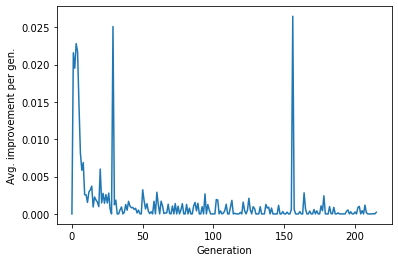

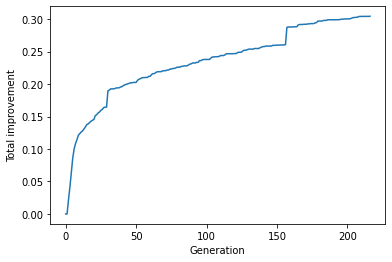

**************************************************************************************************** 
Generation 216/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 1.5176188297605364e-05
Finished evaluating teritory 0
This generation took 0:04:52 to process.
Remaining 283 generations and approximately 16:29:15
Average improvement for generation: 1.5176188297605364e-05 . Average total improvement: 0.3044396382931869


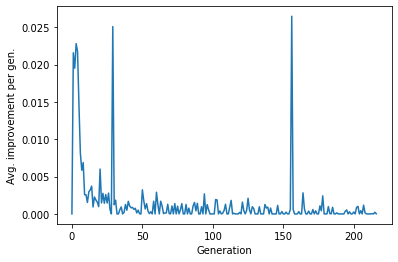

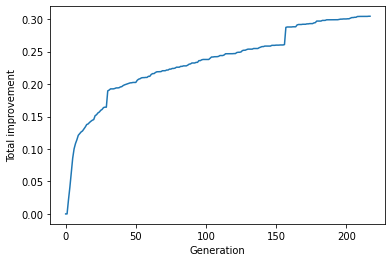

**************************************************************************************************** 
Generation 217/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:01:08 to process.
Remaining 282 generations and approximately 10:53:24
Average improvement for generation: 0.0 . Average total improvement: 0.3044396382931869


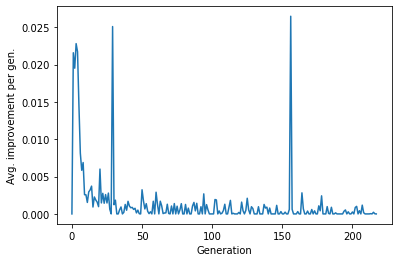

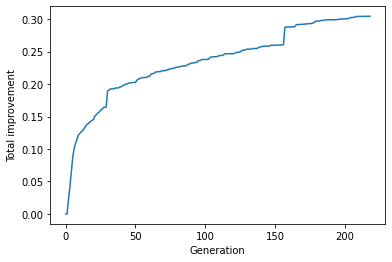

**************************************************************************************************** 
Generation 218/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:03:59 to process.
Remaining 281 generations and approximately 14:45:27
Average improvement for generation: 0.0 . Average total improvement: 0.3044396382931869


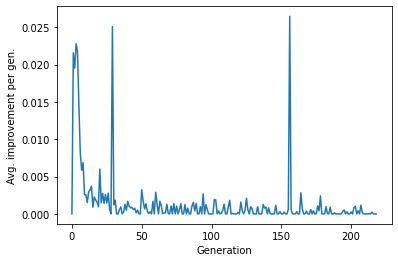

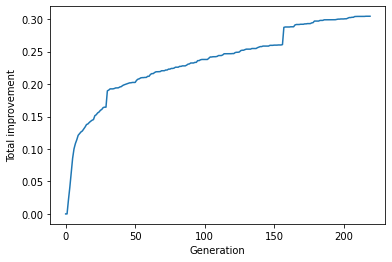

**************************************************************************************************** 
Generation 219/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:27 to process.
Remaining 280 generations and approximately 13:05:22
Average improvement for generation: 0.0 . Average total improvement: 0.3044396382931869


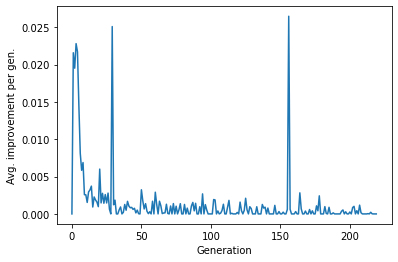

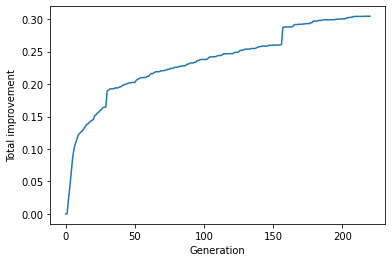

**************************************************************************************************** 
Generation 220/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:01 to process.
Remaining 279 generations and approximately 11:12:46
Average improvement for generation: 0.0 . Average total improvement: 0.3044396382931869


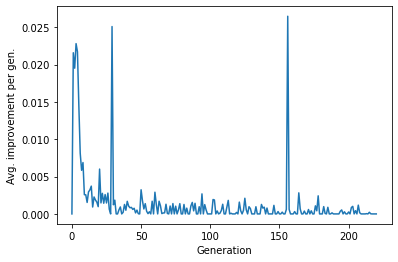

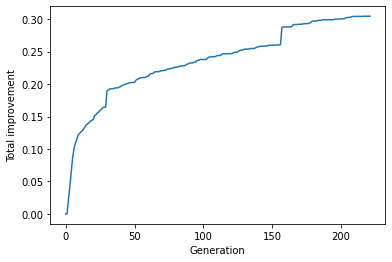

**************************************************************************************************** 
Generation 221/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.020407003241357247
Finished evaluating teritory 0
This generation took 0:03:38 to process.
Remaining 278 generations and approximately 14:02:17
Average improvement for generation: 0.020407003241357247 . Average total improvement: 0.3248466415345441


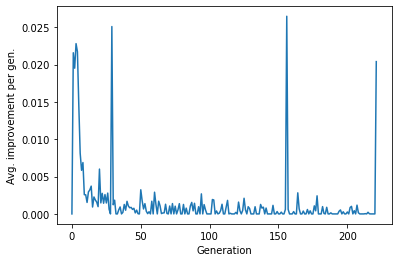

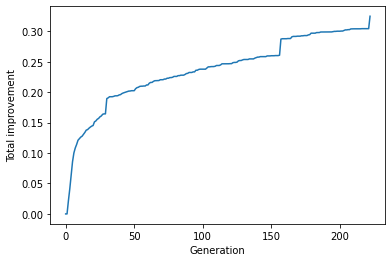

**************************************************************************************************** 
Generation 222/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:03:11 to process.
Remaining 277 generations and approximately 14:20:47
Average improvement for generation: 0.0 . Average total improvement: 0.3248466415345441


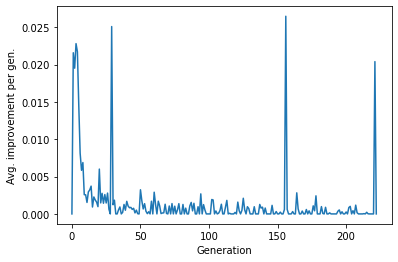

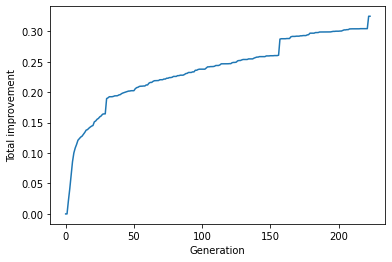

**************************************************************************************************** 
Generation 223/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.00013042677089347698
Finished evaluating teritory 0
This generation took 0:04:56 to process.
Remaining 276 generations and approximately 18:30:48
Average improvement for generation: 0.00013042677089347698 . Average total improvement: 0.3249770683054376


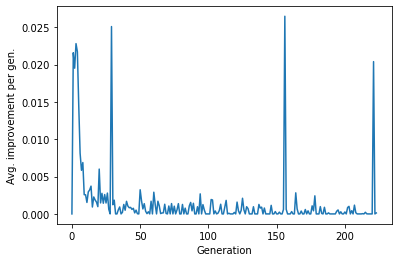

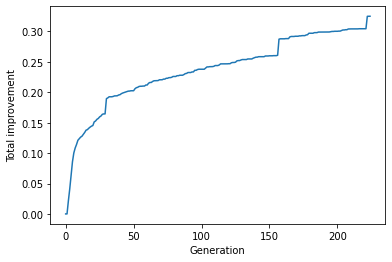

**************************************************************************************************** 
Generation 224/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:03:22 to process.
Remaining 275 generations and approximately 16:57:02
Average improvement for generation: 0.0 . Average total improvement: 0.3249770683054376


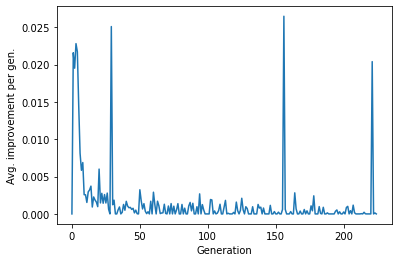

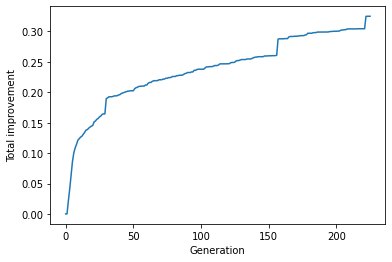

**************************************************************************************************** 
Generation 225/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:01:51 to process.
Remaining 274 generations and approximately 12:41:49
Average improvement for generation: 0.0 . Average total improvement: 0.3249770683054376


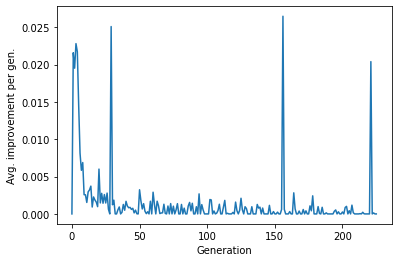

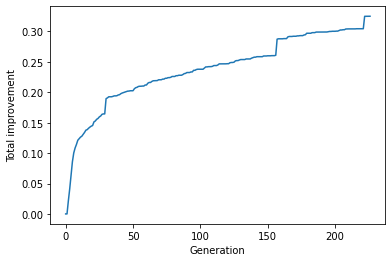

**************************************************************************************************** 
Generation 226/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.00042196270262495617
Finished evaluating teritory 0
This generation took 0:02:34 to process.
Remaining 273 generations and approximately 12:11:42
Average improvement for generation: 0.00042196270262495617 . Average total improvement: 0.32539903100806256


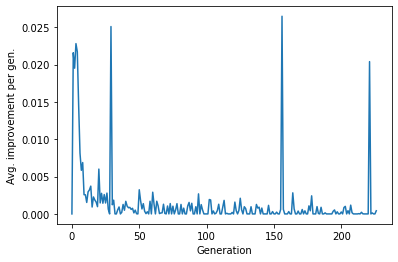

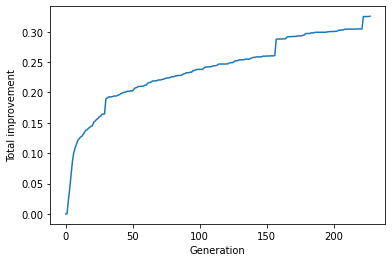

**************************************************************************************************** 
Generation 227/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:45 to process.
Remaining 272 generations and approximately 12:19:15
Average improvement for generation: 0.0 . Average total improvement: 0.32539903100806256


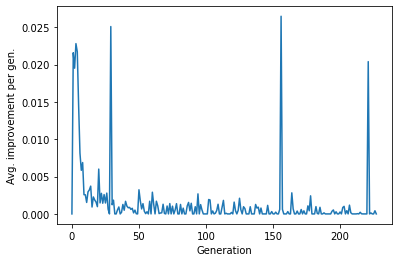

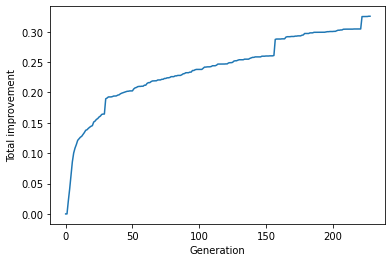

**************************************************************************************************** 
Generation 228/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.000861094812355967
Finished evaluating teritory 0
This generation took 0:03:59 to process.
Remaining 271 generations and approximately 15:08:16
Average improvement for generation: 0.000861094812355967 . Average total improvement: 0.3262601258204185


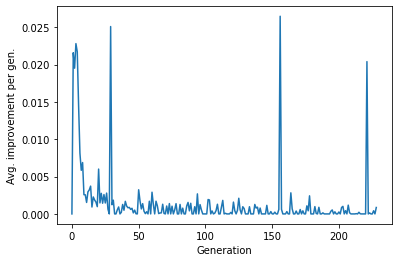

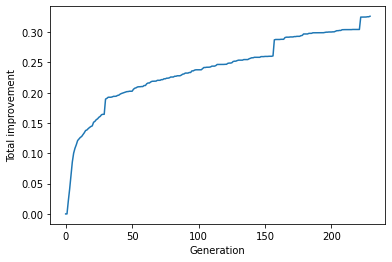

**************************************************************************************************** 
Generation 229/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:26 to process.
Remaining 270 generations and approximately 13:01:01
Average improvement for generation: 0.0 . Average total improvement: 0.3262601258204185


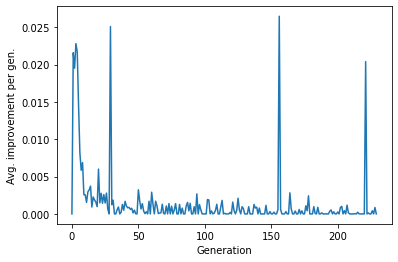

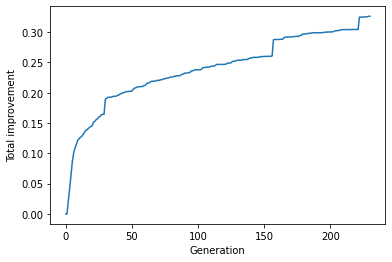

**************************************************************************************************** 
Generation 230/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:10 to process.
Remaining 269 generations and approximately 11:21:50
Average improvement for generation: 0.0 . Average total improvement: 0.3262601258204185


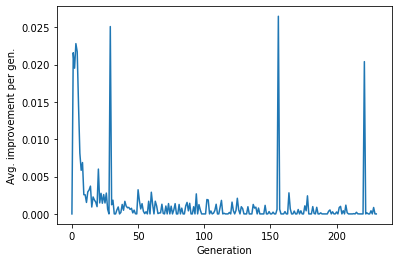

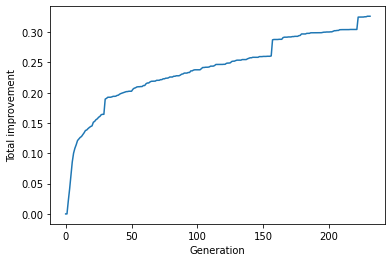

**************************************************************************************************** 
Generation 231/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:04:06 to process.
Remaining 268 generations and approximately 14:50:30
Average improvement for generation: 0.0 . Average total improvement: 0.3262601258204185


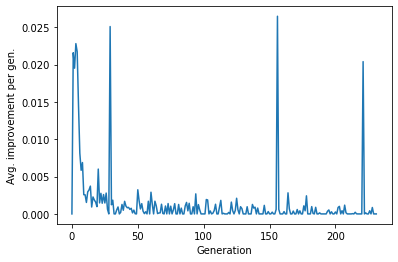

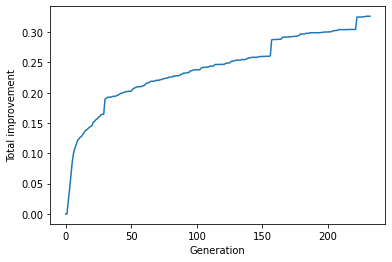

**************************************************************************************************** 
Generation 232/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:17 to process.
Remaining 267 generations and approximately 12:29:30
Average improvement for generation: 0.0 . Average total improvement: 0.3262601258204185


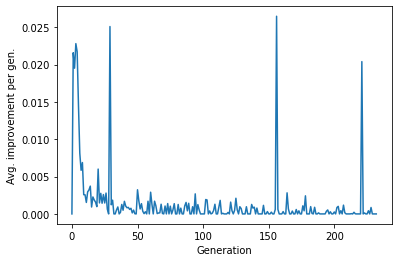

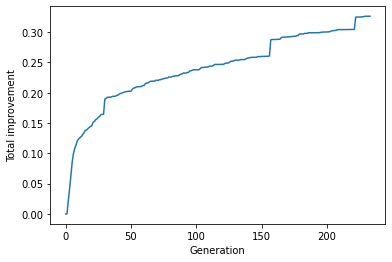

**************************************************************************************************** 
Generation 233/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:16 to process.
Remaining 266 generations and approximately 11:16:52
Average improvement for generation: 0.0 . Average total improvement: 0.3262601258204185


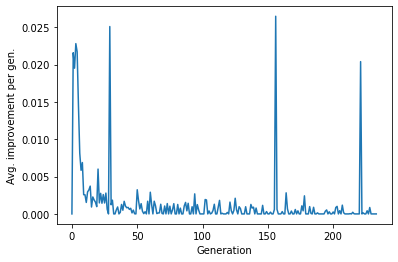

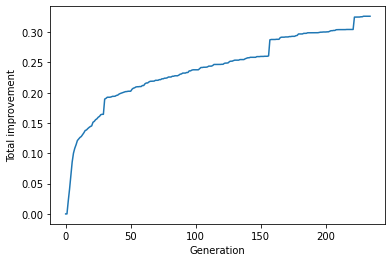

**************************************************************************************************** 
Generation 234/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0014737025864690612
Finished evaluating teritory 0
This generation took 0:05:41 to process.
Remaining 265 generations and approximately 18:11:30
Average improvement for generation: 0.0014737025864690612 . Average total improvement: 0.3277338284068876


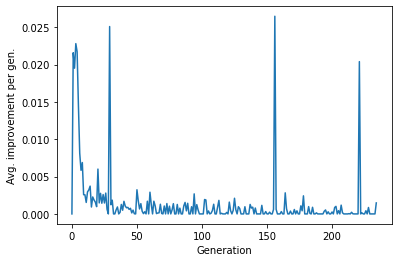

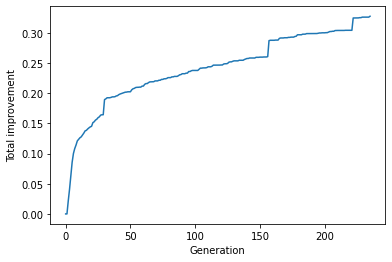

**************************************************************************************************** 
Generation 235/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0002987718259954697
Finished evaluating teritory 0
This generation took 0:04:00 to process.
Remaining 264 generations and approximately 17:53:00
Average improvement for generation: 0.0002987718259954697 . Average total improvement: 0.32803260023288305


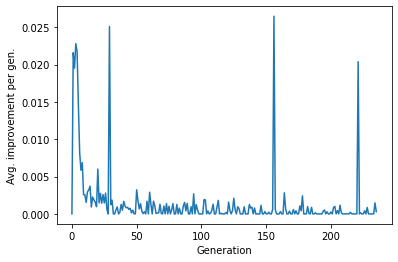

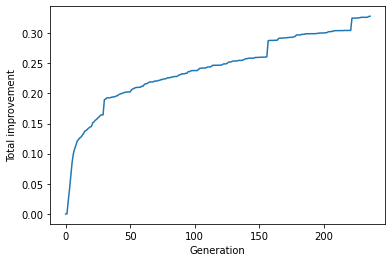

**************************************************************************************************** 
Generation 236/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:32 to process.
Remaining 263 generations and approximately 14:29:38
Average improvement for generation: 0.0 . Average total improvement: 0.32803260023288305


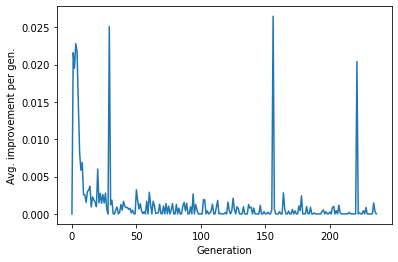

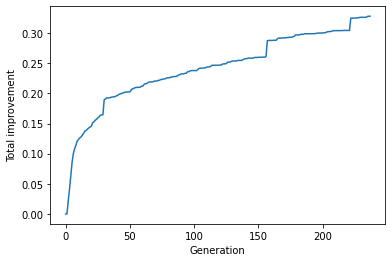

**************************************************************************************************** 
Generation 237/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0011841913163022078
Finished evaluating teritory 0
This generation took 0:02:05 to process.
Remaining 262 generations and approximately 11:46:38
Average improvement for generation: 0.0011841913163022078 . Average total improvement: 0.32921679154918526


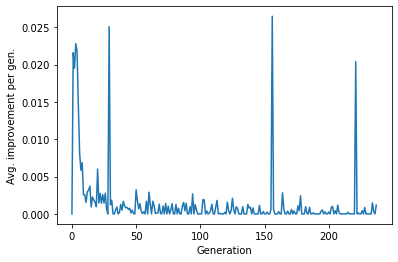

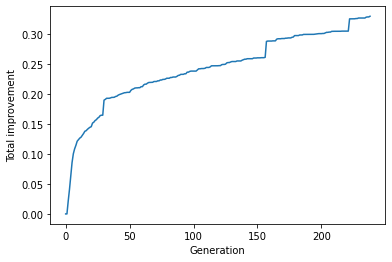

**************************************************************************************************** 
Generation 238/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:19 to process.
Remaining 261 generations and approximately 10:54:24
Average improvement for generation: 0.0 . Average total improvement: 0.32921679154918526


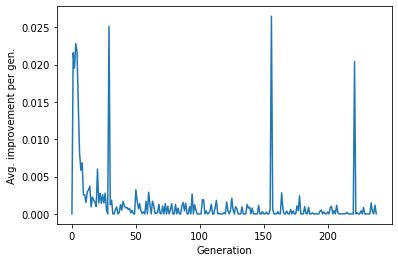

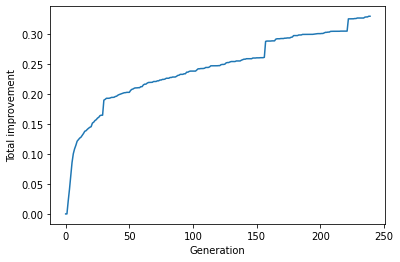

**************************************************************************************************** 
Generation 239/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:01:09 to process.
Remaining 260 generations and approximately 7:57:33
Average improvement for generation: 0.0 . Average total improvement: 0.32921679154918526


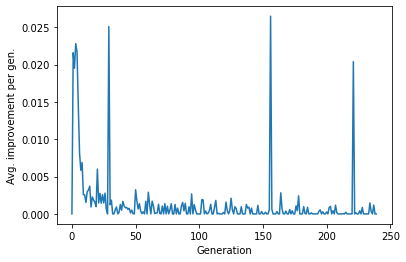

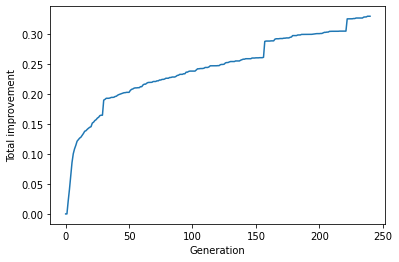

**************************************************************************************************** 
Generation 240/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.000441963919981303
Finished evaluating teritory 0
This generation took 0:02:29 to process.
Remaining 259 generations and approximately 9:20:43
Average improvement for generation: 0.000441963919981303 . Average total improvement: 0.32965875546916656


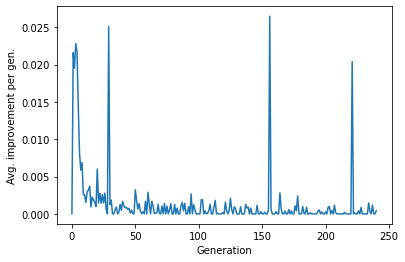

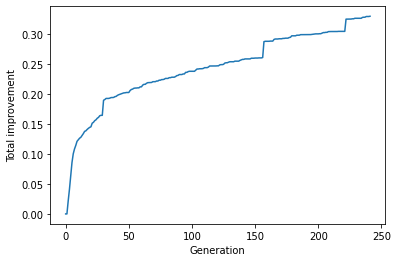

**************************************************************************************************** 
Generation 241/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:03:12 to process.
Remaining 258 generations and approximately 11:32:42
Average improvement for generation: 0.0 . Average total improvement: 0.32965875546916656


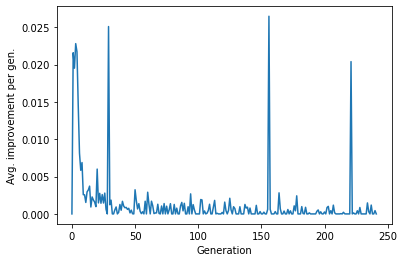

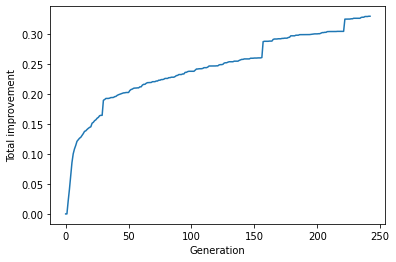

**************************************************************************************************** 
Generation 242/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:00:56 to process.
Remaining 257 generations and approximately 7:46:45
Average improvement for generation: 0.0 . Average total improvement: 0.32965875546916656


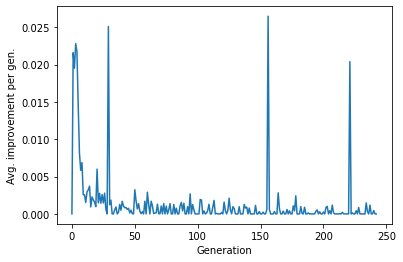

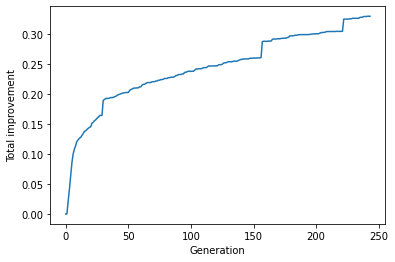

**************************************************************************************************** 
Generation 243/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:03:30 to process.
Remaining 256 generations and approximately 11:22:05
Average improvement for generation: 0.0 . Average total improvement: 0.32965875546916656


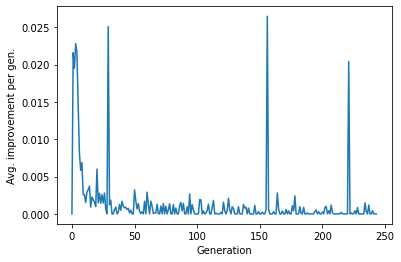

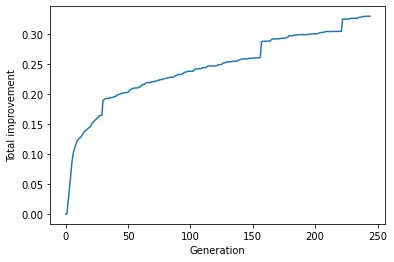

**************************************************************************************************** 
Generation 244/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:03:19 to process.
Remaining 255 generations and approximately 12:42:55
Average improvement for generation: 0.0 . Average total improvement: 0.32965875546916656


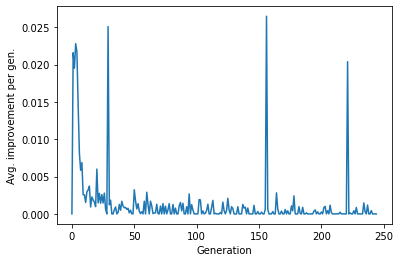

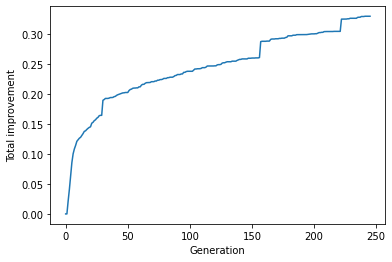

**************************************************************************************************** 
Generation 245/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.00023842334677470767
Finished evaluating teritory 0
This generation took 0:04:24 to process.
Remaining 254 generations and approximately 15:40:34
Average improvement for generation: 0.00023842334677470767 . Average total improvement: 0.32989717881594127


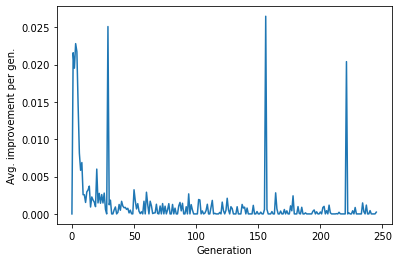

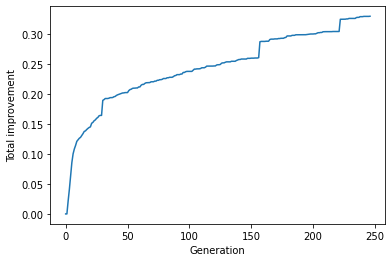

**************************************************************************************************** 
Generation 246/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:03:56 to process.
Remaining 253 generations and approximately 16:07:10
Average improvement for generation: 0.0 . Average total improvement: 0.32989717881594127


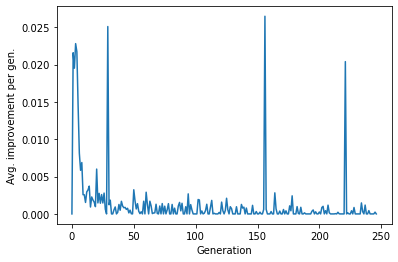

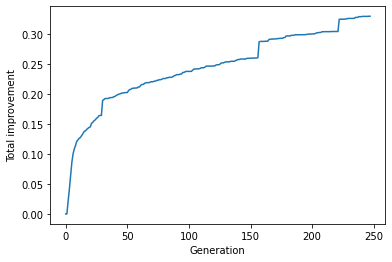

**************************************************************************************************** 
Generation 247/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:54 to process.
Remaining 252 generations and approximately 14:08:53
Average improvement for generation: 0.0 . Average total improvement: 0.32989717881594127


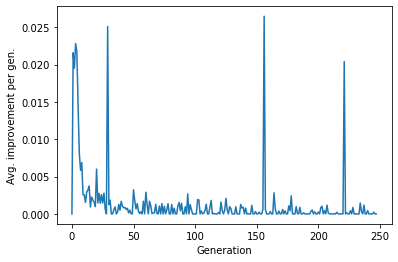

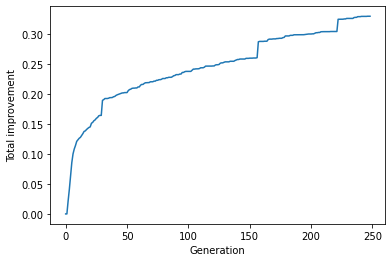

**************************************************************************************************** 
Generation 248/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0008804588684760972
Finished evaluating teritory 0
This generation took 0:03:57 to process.
Remaining 251 generations and approximately 15:19:09
Average improvement for generation: 0.0008804588684760972 . Average total improvement: 0.33077763768441737


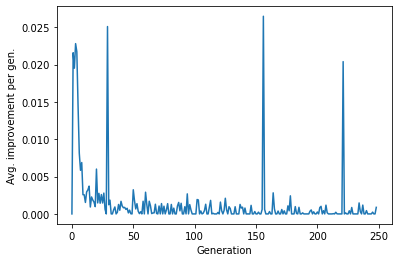

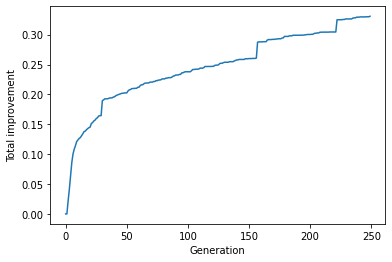

**************************************************************************************************** 
Generation 249/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:15 to process.
Remaining 250 generations and approximately 12:21:02
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


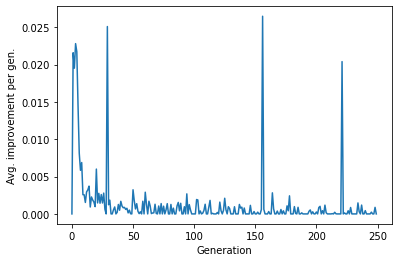

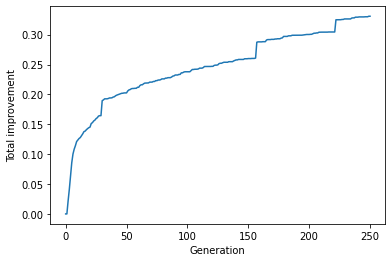

**************************************************************************************************** 
Generation 250/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:03:12 to process.
Remaining 249 generations and approximately 12:48:39
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


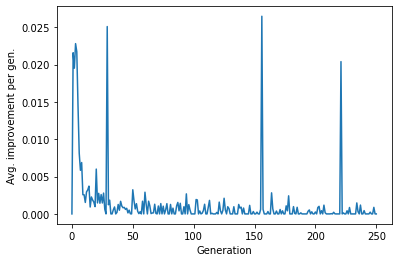

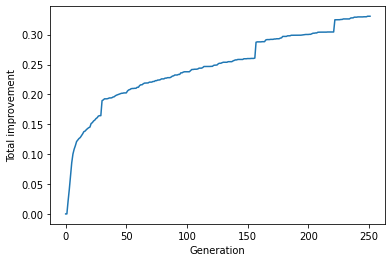

**************************************************************************************************** 
Generation 251/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:12 to process.
Remaining 248 generations and approximately 10:57:38
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


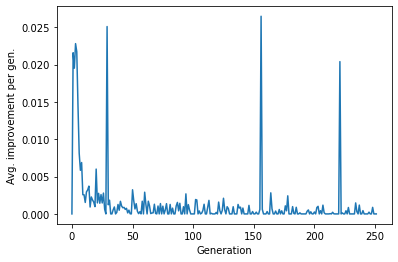

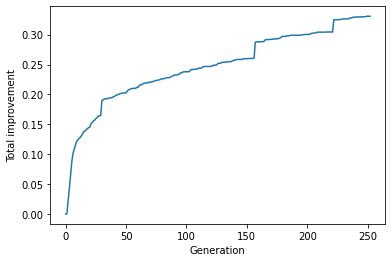

**************************************************************************************************** 
Generation 252/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:01:32 to process.
Remaining 247 generations and approximately 8:37:30
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


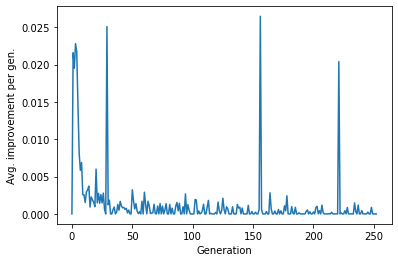

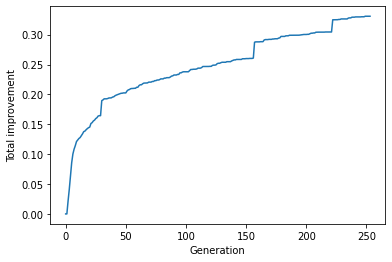

**************************************************************************************************** 
Generation 253/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:19 to process.
Remaining 246 generations and approximately 9:03:24
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


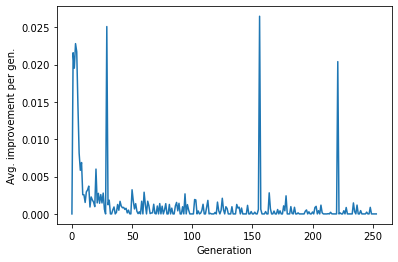

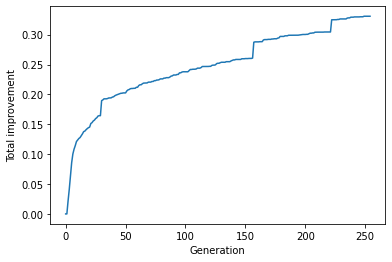

**************************************************************************************************** 
Generation 254/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:21 to process.
Remaining 245 generations and approximately 9:19:58
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


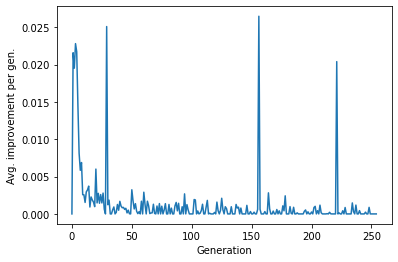

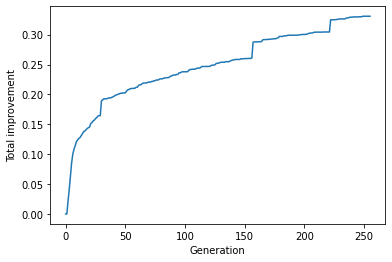

**************************************************************************************************** 
Generation 255/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:01:32 to process.
Remaining 244 generations and approximately 7:45:59
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


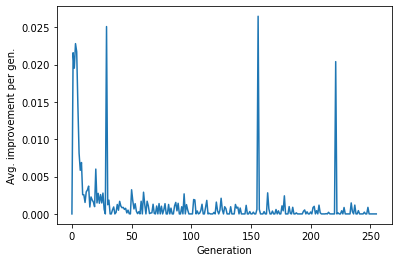

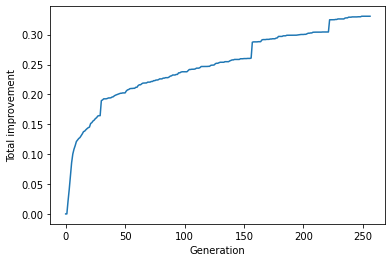

**************************************************************************************************** 
Generation 256/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:01:44 to process.
Remaining 243 generations and approximately 7:24:35
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


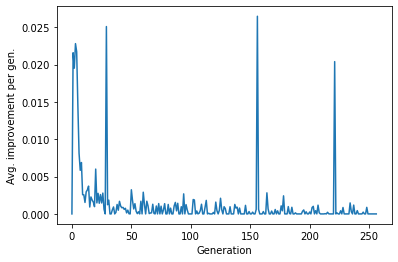

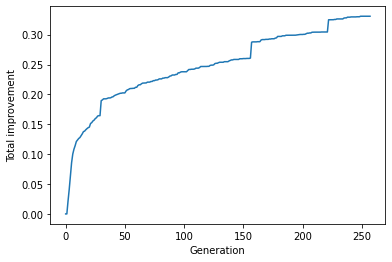

**************************************************************************************************** 
Generation 257/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:04:24 to process.
Remaining 242 generations and approximately 12:35:13
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


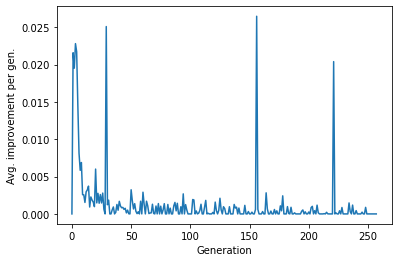

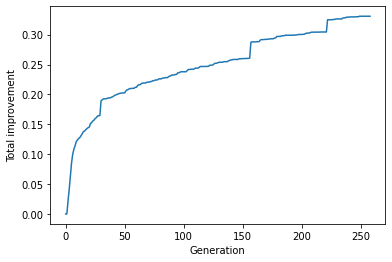

**************************************************************************************************** 
Generation 258/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:30 to process.
Remaining 241 generations and approximately 11:17:56
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


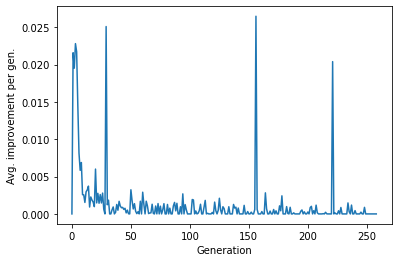

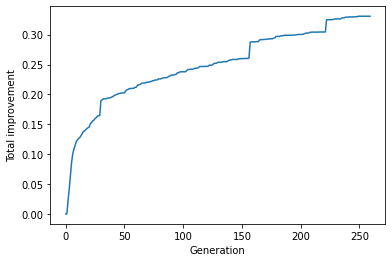

**************************************************************************************************** 
Generation 259/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:03:38 to process.
Remaining 240 generations and approximately 12:55:15
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


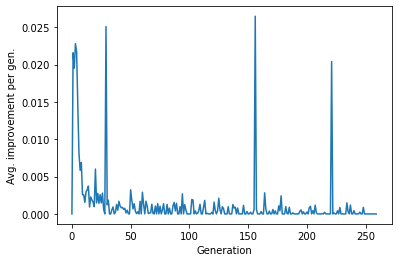

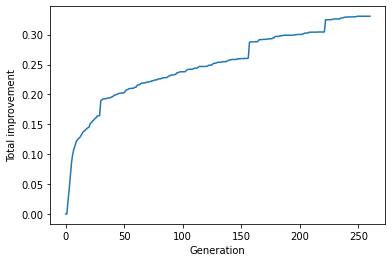

**************************************************************************************************** 
Generation 260/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:01:32 to process.
Remaining 239 generations and approximately 9:30:48
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


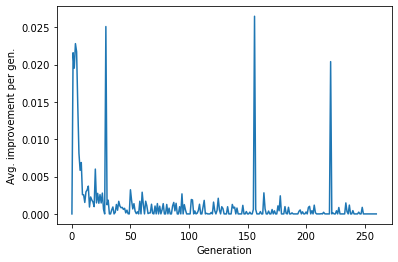

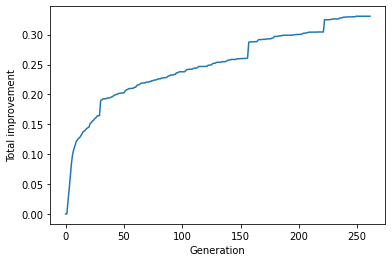

**************************************************************************************************** 
Generation 261/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:02:55 to process.
Remaining 238 generations and approximately 10:31:51
Average improvement for generation: 0.0 . Average total improvement: 0.33077763768441737


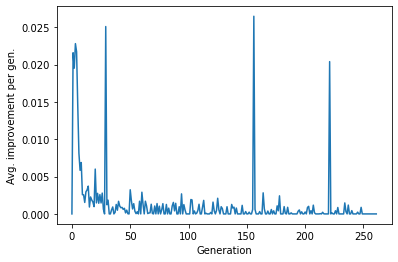

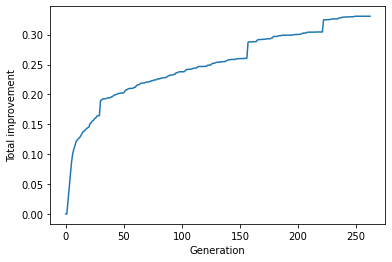

**************************************************************************************************** 
Generation 262/500
......................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0007721393927235809
Finished evaluating teritory 0
This generation took 0:05:55 to process.
Remaining 237 generations and approximately 16:57:11
Average improvement for generation: 0.0007721393927235809 . Average total improvement: 0.33154977707714095


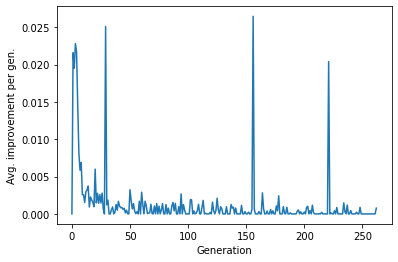

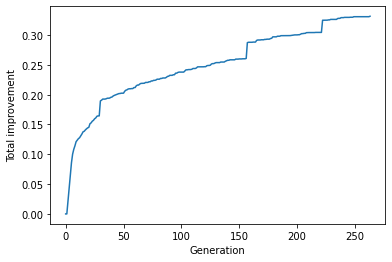

**************************************************************************************************** 
Generation 263/500
.....................................................................................................................................................
Best MAE for teritory 0 is 21487.973808189687 . Average improvement is 0.0
Finished evaluating teritory 0
This generation took 0:05:08 to process.
Remaining 236 generations and approximately 18:32:26
Average improvement for generation: 0.0 . Average total improvement: 0.33154977707714095


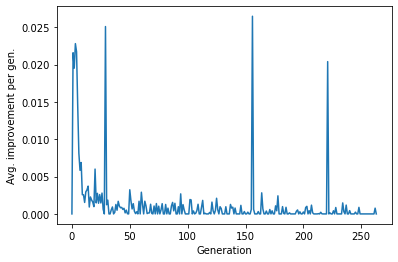

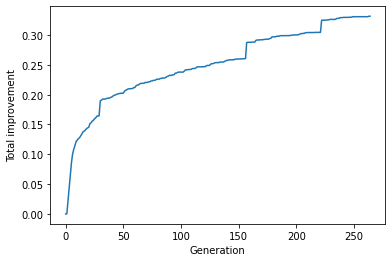

**************************************************************************************************** 
Generation 264/500
.....................................................................................................................................................

In [ ]:
# Hyper parameter tuning (using a genetic algorithm)

n_features = len(preped_X_train.columns)
n_samples = preped_X_train.shape[0]
pop_size = 150
n_generations = 500
n_teritories = 1
# MIN_SURVIVORS = 5
n_survivors = int(0.8 * pop_size)
drift_threshold = 0.001
small_step_mutation_rate = 0.1
large_step_mutation_rate = 0.01

param_limits = {
    'n_estimators':             (1, 1000),
    'max_depth':                (1, n_features),
    'min_samples_split':        (2, 1000),
    'min_samples_leaf':         (1, 1000),
    'min_weight_fraction_leaf': (0, 0.5),
    'max_features':             (1, n_features),
    'max_leaf_nodes':           (2, 10000),
    'min_impurity_decrease':    (0, 1),
    'bootstrap':                (True, False),
    'oob_score':                (True, False),
    'ccp_alpha':                (0, 1),
    'max_samples':              (1, n_samples),
}

"""
Format of ecosystem is:
{
  'last_generation': int,
  'times': [float,...],
  'improvements': [float,...],
  'average_total_improve': [float,...],
  'runtime_running_avg': float,
  'avg_mae_survivors': [{
    'generation': int,
    'values': [None] * n_teritories,
  }],
  'teritories': [
    [{hp:{}, mae=None},...],
    .
    .
    .
  ]
}
"""
ecosystem = {
    'last_generation': 0,
    'times': [],
    'improvements': [],
    'average_total_improve': [0],
    'runtime_running_avg': 0,
    'avg_mae_survivors': [],
    'teritories': []
}


def init_env(ecosystem):
  teritories = []
  for i in range(n_teritories):
    teritories.append([])
  ecosystem['teritories'] = teritories


def init_HP():
  """
  Provides a randomly initialized set of hyper parameters for a RandomForestRegressor
  """

  global n_features, n_samples, param_limits

  HP = {
      'n_estimators': int(random.randint(*param_limits['n_estimators'])),
      'max_depth': int(random.randint(*param_limits['max_depth'])),
      'min_samples_split': int(random.randint(*param_limits['min_samples_split'])),
      'min_samples_leaf': int(random.randint(*param_limits['min_samples_leaf'])),
      'min_weight_fraction_leaf': random.uniform(*param_limits['min_weight_fraction_leaf']),
      'max_features': int(random.randint(*param_limits['max_features'])),
      'max_leaf_nodes': int(random.randint(*param_limits['max_leaf_nodes'])),
      'min_impurity_decrease': random.uniform(*param_limits['min_impurity_decrease']),
      'bootstrap': bool(random.choice((True, False))),
      'oob_score': False,
      'ccp_alpha': random.uniform(*param_limits['ccp_alpha']),
      'max_samples': int(random.randint(*param_limits['max_samples'])),
  }

  if HP['bootstrap'] == True:
    HP['oob_score'] = bool(random.choice((True, False)))
  
  return HP


def evaluate_model(model, X_train, X_cv, y_train, y_cv):
  model.fit(X_train, y_train)
  pred = model.predict(X_cv)
  return mean_absolute_error(pred, y_cv)


def ragnge_size(limits):
  return limits[1] - limits[0]


def small_step_mutation(zygote):
  zygote['n_estimators'] = max(1, zygote['n_estimators'] + int(np.random.normal(0, ragnge_size(param_limits['n_estimators']) * small_step_mutation_rate)))
  zygote['max_depth'] = min(max(1, zygote['max_depth'] + int(np.random.normal(0, int(ragnge_size(param_limits['max_depth']) * small_step_mutation_rate)))), n_features)
  zygote['min_samples_split'] = max(2, zygote['min_samples_split'] + int(np.random.normal(0, ragnge_size(param_limits['min_samples_split']) * small_step_mutation_rate)))
  zygote['min_samples_leaf'] = max(1, zygote['min_samples_leaf'] + int(np.random.normal(0, ragnge_size(param_limits['min_samples_leaf']) * small_step_mutation_rate)))
  zygote['min_weight_fraction_leaf'] = min(max(0, zygote['min_weight_fraction_leaf'] + np.random.normal(0, ragnge_size(param_limits['min_weight_fraction_leaf']) * small_step_mutation_rate)), 0.5)
  zygote['max_features'] = min(max(1, zygote['max_features'] + int(np.random.normal(0, int(ragnge_size(param_limits['max_features']) * small_step_mutation_rate)))), n_features)
  zygote['max_leaf_nodes'] = max(2, zygote['max_leaf_nodes'] + int(np.random.normal(0, ragnge_size(param_limits['max_leaf_nodes']) * small_step_mutation_rate)))
  zygote['min_impurity_decrease'] += max(0, np.random.normal(0, ragnge_size(param_limits['min_impurity_decrease']) * small_step_mutation_rate))
  zygote['bootstrap'] = bool(np.random.choice([True, False], p=[1 - small_step_mutation_rate if x==zygote['bootstrap'] else small_step_mutation_rate for x in [True, False]]))
  zygote['oob_score'] = bool(np.random.choice([True, False], p=[1 - small_step_mutation_rate if x==zygote['oob_score'] else small_step_mutation_rate for x in [True, False]]))
  zygote['ccp_alpha'] = max(0, zygote['ccp_alpha'] + int(np.random.normal(0, ragnge_size(param_limits['ccp_alpha']) * small_step_mutation_rate)))
  zygote['max_samples'] = min(max(1, zygote['max_samples'] + int(np.random.normal(0, ragnge_size(param_limits['max_samples']) * small_step_mutation_rate))), n_samples)

  if zygote['bootstrap'] == False:
    zygote['oob_score'] = False
  
  return zygote


def should_do_large_step():
  return np.random.choice([True, False], p=[1 - large_step_mutation_rate, large_step_mutation_rate])


def large_step_mutation(zygote):
  global param_limits

  if should_do_large_step():
    zygote['n_estimators'] = int(random.randint(*param_limits['n_estimators']))
  if should_do_large_step():
    zygote['max_depth'] = int(random.randint(*param_limits['max_depth']))
  if should_do_large_step():
    zygote['min_samples_split'] = int(random.randint(*param_limits['min_samples_split']))
  if should_do_large_step():
    zygote['min_samples_leaf'] = int(random.randint(*param_limits['min_samples_leaf']))
  if should_do_large_step():
    zygote['min_weight_fraction_leaf'] = random.uniform(*param_limits['min_weight_fraction_leaf'])
  if should_do_large_step():
    zygote['max_features'] = int(random.randint(*param_limits['max_features']))
  if should_do_large_step():
    zygote['max_leaf_nodes'] = int(random.randint(*param_limits['max_leaf_nodes']))
  if should_do_large_step():
    zygote['min_impurity_decrease'] = random.uniform(*param_limits['min_impurity_decrease'])
  if should_do_large_step():
    zygote['bootstrap'] = bool(random.choice((True, False)))
  if should_do_large_step():
    zygote['oob_score'] = bool(random.choice((True, False)))
  if should_do_large_step():
    zygote['ccp_alpha'] = random.uniform(*param_limits['ccp_alpha'])
  if should_do_large_step():
    zygote['max_samples'] = int(random.randint(*param_limits['max_samples']))

  if zygote['bootstrap'] == False:
    zygote['oob_score'] = False
  
  return zygote


def mutate(zygote):
  zygote = small_step_mutation(zygote)
  zygote = large_step_mutation(zygote)
  return zygote


def fertilize(male, female):
  parents = [male, female]

  return mutate({
      'n_estimators': random.choice(parents)['hp']['n_estimators'],
      'max_depth': random.choice(parents)['hp']['max_depth'],
      'min_samples_split': random.choice(parents)['hp']['min_samples_split'],
      'min_samples_leaf': random.choice(parents)['hp']['min_samples_leaf'],
      'min_weight_fraction_leaf': random.choice(parents)['hp']['min_weight_fraction_leaf'],
      'max_features': random.choice(parents)['hp']['max_features'],
      'max_leaf_nodes': random.choice(parents)['hp']['max_leaf_nodes'],
      'min_impurity_decrease': random.choice(parents)['hp']['min_impurity_decrease'],
      'bootstrap': random.choice(parents)['hp']['bootstrap'],
      'oob_score': random.choice(parents)['hp']['oob_score'],
      'ccp_alpha': random.choice(parents)['hp']['ccp_alpha'],
      'max_samples': random.choice(parents)['hp']['max_samples'],
  })


def breed(population):
  # normal = [abs(x) for x in random_gen.normal(0, n_survivors, size=len(population))]
  # probs = sorted([x / sum(normal) for x in normal], reverse=True)
  # male, female = random_gen.choice(population, replace=False, size=2, p=probs)
  male, female = random_gen.choice(population[:n_survivors], replace=False, size=2)
  return {'hp': fertilize(male, female), 'mae': None}


def perform_drift(teritories, idx):
  teritory_1 = teritories[idx]
  teritory_2 = random.choice([x for x in teritories if x is not teritory_1])
  specimen_1 = random_gen.choice(teritory_1)
  specimen_2 = random_gen.choice(teritory_2)
  teritory_1.remove(specimen_1)
  teritory_2.remove(specimen_2)
  teritory_1.append(specimen_2)
  teritory_2.append(specimen_1)


class Survivor:
  def __init__(self, hp, mae):
    self.hp = hp
    self.mae = mae
  
  def __lt__(self, other):
    return self.mae < other.mae
  
  def to_dict(self):
    return {'hp': self.hp, 'mae': self.mae}


def seconds2timestr(seconds): 
  hour = seconds // 3600
  seconds %= 3600
  minutes = seconds // 60
  seconds %= 60
  
  return "%d:%02d:%02d" % (hour, minutes, seconds)


def process_specimen(population, idx):
  global preped_X_train, preped_X_cv, y_train, y_cv
  if population[idx]['mae'] is None:
    model = model_from_hp(population[idx]['hp'])
    population[idx]['mae'] = evaluate_model(model, preped_X_train, preped_X_cv, y_train, y_cv)
  return population[idx]


def process_teritory(ecosystem, need_drift, idx, executor):
    teritories = ecosystem['teritories']
    futures = [executor.submit(process_specimen, teritories[idx], i) for i in range(len(teritories[idx]))]
    survivors = []
    for future in concurrent.futures.as_completed(futures):
        heapq.heappush(survivors, Survivor(**future.result()))
        print('.', end='')
    normal = random_gen.normal(0, n_survivors, size=len(teritories[idx]))
    abs_normal = np.abs(normal)
    probs = abs_normal / np.sum(abs_normal)
    sorted_probs = sorted(probs, reverse=True)
    for i in range(n_survivors, len(sorted_probs)):
      for j in range(n_survivors):
        sorted_probs[j] += sorted_probs[i] / 2
        sorted_probs[i] /= 2
    survivors = random_gen.choice(survivors, replace=False, size=n_survivors, p=sorted_probs)
    survivors = sorted(survivors.tolist())
    # survivors = heapq.nsmallest(n_survivors, survivors)
    new_avg_mae_survivors = np.mean([x.mae for x in survivors])
    try:
        improvement = ecosystem['avg_mae_survivors'][-2]['values'][idx] / new_avg_mae_survivors - 1
        if improvement < drift_threshold:
            need_drift[idx] = True
    except:
        improvement = 0
    ecosystem['avg_mae_survivors'][-1]['values'][idx] = new_avg_mae_survivors
    print("\nBest MAE for teritory", idx, "is", survivors[0].mae, ". Average improvement is", improvement)
    teritories[idx] = [x.to_dict() for x in survivors]
    offsprings = []
    futures = [executor.submit(breed, teritories[idx]) for i in range((pop_size - len(teritories[idx])))]
    for future in concurrent.futures.as_completed(futures):
        offsprings.append(future.result())
    teritories[idx] += offsprings
    print("Finished evaluating teritory", idx)
    return improvement


try:
  with open(os.path.join(project_files_path, 'ecosystem.json')) as f:
    ecosystem = json.load(f)
    generations_passed = ecosystem['last_generation'] + 1
except Exception as e:
  for i in range(n_teritories):
    ecosystem['teritories'].append([{'hp': init_HP(), 'mae': None} for i in range(int(pop_size))])
  generations_passed = 0

# Supress warnings to avoid terminal clutter
logging.captureWarnings(True)


# def rec_eco(ecosystem):
#   for key in ecosystem:
#     if type(ecosystem[key]) == np.ndarray:
#       print(key, "is an ndarray")
#     else:
#       try:
#         print('iterating', key)
#         rec_eco(ecosystem[key])
#       except:
#         continue


# times = []
with concurrent.futures.ThreadPoolExecutor() as executor:
  for generation in range(generations_passed, n_generations):
    print("*" * 100, "\nGeneration", str(generation) + '/' + str(n_generations))
    start_time = time.time()
    need_drift = [False] * n_teritories
    ecosystem['avg_mae_survivors'].append({'generation': generation, 'values':[0] * n_teritories})
    improvements = []
    futures = [executor.submit(process_teritory, ecosystem, need_drift, idx, executor) for idx in range(len(ecosystem['teritories']))]
    for future in concurrent.futures.as_completed(futures):
      improvements.append(future.result())
    average_improve = float(np.mean(improvements))
    ecosystem['average_total_improve'].append(ecosystem['average_total_improve'][-1] + average_improve)
    ecosystem['improvements'].append(average_improve)
    sum_drifts = sum(need_drift)
    # n_survivors = max(MIN_SURVIVORS, min(pop_size - 5, n_survivors - 2 + sum_drifts))
    small_step_mutation_rate = 0.1 * (sum_drifts + 1)
    large_step_mutation_rate = 0.01 * (sum_drifts + 1)
    # print("Need drift:", sum_drifts)
    # for i in range(len(need_drift)):
    #   if need_drift[i] is True:
    #     perform_drift(ecosystem['teritories'], i)
    ecosystem['last_generation'] = generation
    end_time = time.time()
    generation_process_time = end_time - start_time
    ecosystem['runtime_running_avg'] = (ecosystem['runtime_running_avg'] + generation_process_time) / 2
    ecosystem['times'].append(generation_process_time)
    # rec_eco(ecosystem)
    with open(os.path.join(project_files_path, 'ecosystem.json'), 'w') as f:
      json.dump(ecosystem, f)
    remaining_generations = n_generations - generation - 1
    print("This generation took", seconds2timestr(generation_process_time), "to process.")
    print("Remaining", remaining_generations, "generations and approximately", seconds2timestr(ecosystem['runtime_running_avg'] * remaining_generations))
    print("Average improvement for generation:", average_improve, ". Average total improvement:", ecosystem['average_total_improve'][-1])
    plt.plot(ecosystem['improvements'])
    plt.xlabel("Generation")
    plt.ylabel("Avg. improvement per gen.")
    plt.show()
    plt.plot(ecosystem['average_total_improve'])
    plt.xlabel("Generation")
    plt.ylabel("Total improvement")
    plt.show()
    # print("n_survivors:", n_survivors)
    

In [ ]:
# Prepeare test predictions
with open(os.path.join(project_files_path, 'ecosystem.json')) as f:
    ecosystem = json.load(f)

X_train_cv = pd.concat([preped_X_train, preped_X_cv], axis=0)
y_train_cv = pd.concat([y_train, y_cv], axis=0)

best_hp = ecosystem['teritories'][0][0]['hp']
best_mae = ecosystem['teritories'][0][0]['mae']
for teritory in ecosystem['teritories']:
  for specimen in teritory:
    if specimen['mae'] is not None and specimen['mae'] < best_mae:
      best_mae = specimen['mae']
      best_hp = specimen['hp']

print(best_hp)

model = model_from_hp(best_hp)

print("Fitting")

model.fit(X_train_cv, y_train_cv)

print("Predicting")

preds_test = model.predict(preped_X_test)

print("Saving")

output = pd.DataFrame({'Id': preped_X_test.Id.astype('int32'),
                       'SalePrice': preds_test})
output.to_csv(os.path.join(project_files_path, 'submission_gen.csv'), index=False)

In [ ]:
output = pd.DataFrame({'Id': preped_X_test.Id.astype('int32'),
                       'SalePrice': preds_test})
output.to_csv(os.path.join(project_files_path, 'submission_gen.csv'), index=False)